In [21]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.daf.butler as dafButler
import lsst.geom as geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# Butler configuration
REPO = "dp2_prep"
COLLECTIONS = "LSSTCam/runs/DRP/DP2/v30_0_0/DM-53881/stage2"
#WHERE = "instrument='LSSTCam' AND day_obs>=20250801 AND day_obs<=20250921 AND band in ('u')"
WHERE = "instrument='LSSTCam' AND band in ('u')"
N_DETECTORS = 20
N_INJECT_PER_DETECTOR = 300
MAG_OFFSET = 0.5
PARALLEL = 4
SEED = 123
TRAIL_LENGTH = [0.0, 0.0]
BETA = [0.0, 0.0]

In [46]:
butler = dafButler.Butler(REPO, collections=COLLECTIONS)

refs = list(set(
    butler.registry.queryDatasets(
        "preliminary_visit_image",
        instrument="LSSTCam",
        findFirst=True,
        where=WHERE
    )
))

print ("Found data:", len(refs))
refs = sorted(refs, key=lambda r: (int(r.dataId["visit"]), int(r.dataId["detector"])))
ref_indexes = np.random.choice(range(len(refs)), N_DETECTORS, replace=False)
refs = np.array(refs)[ref_indexes]
dims = butler.get("preliminary_visit_image.dimensions", dataId=refs[0].dataId)

rows = []
for ref in refs:
    calexp = butler.get("preliminary_visit_image", dataId=ref.dataId)

    m5_stack = float(calexp.info.getSummaryStats().magLim)
    rows.append({
        "visit": int(ref.dataId["visit"]),
        "detector": int(ref.dataId["detector"]),
        "m5_stack": m5_stack,
    })

det_df = pd.DataFrame(rows)

Found data: 370310


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


In [62]:
import concurrent.futures
import traceback

def worker_df(args):
    """
    Run one_detector_injection for one (visit,detector) with point sources around m5.
    Returns: (status, dataId, err, tb, df)
    """
    (dataId, repo, coll, number, trail_length, mag_range, beta, source_type, seed, mag_mode, psf_template) = args

    # stable per (visit,detector)
    s = (int(seed) * 1_000_003 + int(dataId["visit"]) * 1_003 + int(dataId["detector"])) & 0xFFFFFFFF

    res = one_detector_injection(
        number,
        trail_length,
        mag_range,
        beta,
        repo,
        coll,
        source_type,
        dataId,
        s,
        debug=False,
        mag_mode=mag_mode,
        psf_template=psf_template,
    )

    if res[0] is False:
        _, bad_dataId, err, tb = res
        return ("err", bad_dataId, err, tb, None)

    _, img, mask, real_labels, catalog = res
    df = catalog.to_pandas()
    df["visit"] = int(dataId["visit"])
    df["detector"] = int(dataId["detector"])
    return ("ok", dataId, None, None, df)


def run_injections_df_for_detectors(det_df, *, repo, coll, n_inject, mag_offset, trail_length, beta,
                                   parallel, seed, mag_mode, psf_template):
    """
    For each (visit,detector) in det_df (with column m5_stack), inject point sources in [m5-Δ, m5+Δ]
    and return concatenated DataFrame + errors.
    """
    tasks = []
    for r in det_df.itertuples(index=False):
        dataId = {"visit": int(r.visit), "detector": int(r.detector)}
        mag_range = [float(r.m5_stack) - mag_offset, float(r.m5_stack) + mag_offset]
        tasks.append((dataId, repo, coll, n_inject, trail_length, mag_range, beta,
                      "preliminary_visit_image", seed, mag_mode, psf_template))

    dfs = []
    errors = []
    total = len(tasks)

    if parallel > 1:
        with concurrent.futures.ProcessPoolExecutor(max_workers=parallel) as ex:
            futs = [ex.submit(worker_df, t) for t in tasks]
            done = 0
            for fut in concurrent.futures.as_completed(futs):
                done += 1
                status, dataId, err, tb, df = fut.result()
                if status == "ok":
                    dfs.append(df)
                    print(f"[{done}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
                else:
                    errors.append((dataId, err, tb))
                    print(f"[{done}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                    print(err, flush=True)
                    print(tb, flush=True)
    else:
        for i, t in enumerate(tasks, 1):
            status, dataId, err, tb, df = worker_df(t)
            if status == "ok":
                dfs.append(df)
                print(f"[{i}/{total}] ok visit={dataId['visit']} det={dataId['detector']}", flush=True)
            else:
                errors.append((dataId, err, tb))
                print(f"[{i}/{total}] ERROR visit={dataId['visit']} det={dataId['detector']}", flush=True)
                print(err, flush=True)
                print(tb, flush=True)

    out = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return out, errors

In [63]:
REPO_ROOT = "/sdf/data/rubin/user/mrakovci/Projects/Asteroid_detection_CNN"
DATASET_CREATION = f"{REPO_ROOT}/ADCNN/data/dataset_creation"

for p in [REPO_ROOT, DATASET_CREATION]:
    if p not in sys.path:
        sys.path.insert(0, p)
from ADCNN.data.dataset_creation.simulate_inject import one_detector_injection

all_df, errors = run_injections_df_for_detectors(
    det_df,
    repo=REPO,
    coll=COLLECTIONS,
    n_inject=N_INJECT_PER_DETECTOR,
    mag_offset=MAG_OFFSET,
    trail_length=TRAIL_LENGTH,
    beta=BETA,
    parallel=PARALLEL,
    seed=SEED,
    mag_mode="surface_brightness",
    psf_template="kernel",
)

print("rows:", len(all_df), "errors:", len(errors))
all_df.head()


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.

[1/20] ok visit=2025052300128 det=150


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[2/20] ok visit=2025072000077 det=93


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[3/20] ok visit=2025071600513 det=32


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[4/20] ok visit=2025042900292 det=53


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[5/20] ok visit=2025052800663 det=83


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[6/20] ok visit=2025121900226 det=51


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[7/20] ok visit=2025052300319 det=73


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[8/20] ok visit=2025052300095 det=93


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[9/20] ok visit=2025050300734 det=132


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[10/20] ok visit=2025050100469 det=179


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[11/20] ok visit=2025052500543 det=160


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[12/20] ok visit=2025042400250 det=141


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[13/20] ok visit=2025072200439 det=21


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[14/20] ok visit=2025072200421 det=84


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[15/20] ok visit=2025071900458 det=22
[16/20] ok visit=2025071800209 det=35


/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/share/eups/Linux64/obs_base/gdab83eb0e6+5b1a939f4f/python/lsst/obs/base/formatters/fitsExposure.py:787: FutureWarning: Summary fields [starEMedian, starUnNormalizedEMedian] not recognized by this software version; ignoring them.
  result = self.reader.read(**self.checked_parameters)


[17/20] ok visit=2025050100616 det=74


[18/20] ok visit=2025062200452 det=127


[19/20] ok visit=2025071900469 det=174


[20/20] ok visit=2025060100666 det=102
rows: 6000 errors: 0


ra       dec source_type  trail_length        mag  beta  \
0  150.861406  3.069711        Star           0.0  23.347614   0.0   
1  150.862916  3.210136        Star           0.0  23.170428   0.0   
2  150.714969  3.082012        Star           0.0  23.324477   0.0   
3  150.836494  3.090400        Star           0.0  23.682121   0.0   
4  150.812916  3.082297        Star           0.0  23.821206   0.0   

           visit  detector  integrated_mag    PSF_mag  ...  physical_filter  \
0  2025052300128       150       23.347614  23.347614  ...                u   
1  2025052300128       150       23.170428  23.170428  ...                u   
2  2025052300128       150       23.324477  23.324477  ...                u   
3  2025052300128       150       23.682121  23.682121  ...                u   
4  2025052300128       150       23.821206  23.821206  ...                u   

      x     y  SNR_estimation   m5_local  m5_detector  stack_detection  \
0  1091  2266        7.314368  23.247998    23.570085            False   
1  3256  3570        8.176984  23.239922    23.570085             True   
2  2612   109        7.317637  23.245500    23.570085             True   
3  1638  2069        5.408796  23.249228    23.570085            False   
4  1727  1630        4.652379  23.249602    23.570085            False   

   stack_mag  stack_mag_err  stack_snr  
0        NaN            NaN        NaN  
1  23.026947       0.130259   8.335195  
2  23.263597       0.159300   6.815664  
3        NaN            NaN        NaN  
4        NaN            NaN        NaN  

[5 rows x 21 columns]

In [27]:
d = all_df.copy()
if len(d) == 0:
    raise RuntimeError("No injection results; check errors above.")

# detected flag is your footprint match result
d["detected"] = d["stack_detection"].astype(bool)

# Join m5_stack for convenience
d = d.merge(det_df, on=["visit", "detector"], how="left")

# Use injected PSF_mag for point sources
mag = d["PSF_mag"].astype(float).values
mmin, mmax = np.nanpercentile(mag, [0.5, 99.5])
bins = np.linspace(mmin, mmax, 25)
d["mag_bin"] = pd.cut(d["PSF_mag"], bins)
d["mag_delta1"] = d["mag"] - d["m5_stack"]
d

ra        dec source_type  trail_length        mag  beta  \
0      12.380913 -44.700531        Star           0.0  21.072334   0.0   
1      12.460116 -44.563477        Star           0.0  21.476590   0.0   
2      12.240640 -44.680482        Star           0.0  21.609332   0.0   
3      12.387048 -44.705245        Star           0.0  21.885171   0.0   
4      12.410230 -44.549893        Star           0.0  21.410619   0.0   
...          ...        ...         ...           ...        ...   ...   
5995  306.832230 -23.959611        Star           0.0  21.644084   0.0   
5996  306.948050 -24.040904        Star           0.0  21.358762   0.0   
5997  306.877946 -24.096786        Star           0.0  21.601989   0.0   
5998  306.850946 -24.149320        Star           0.0  21.942559   0.0   
5999  306.811588 -24.026927        Star           0.0  21.447875   0.0   

              visit  detector  integrated_mag    PSF_mag  ...   m5_local  \
0     2025080900283       158       21.072334  21.072334  ...  20.950919   
1     2025080900283       158       21.476590  21.476590  ...  20.941747   
2     2025080900283       158       21.609332  21.609332  ...  20.967572   
3     2025080900283       158       21.885171  21.885171  ...  20.950506   
4     2025080900283       158       21.410619  21.410619  ...  20.939502   
...             ...       ...             ...        ...  ...        ...   
5995  2025081000398         8       21.644084  21.644084  ...  21.052228   
5996  2025081000398         8       21.358762  21.358762  ...  21.039796   
5997  2025081000398         8       21.601989  21.601989  ...  21.035983   
5998  2025081000398         8       21.942559  21.942559  ...  21.036646   
5999  2025081000398         8       21.447875  21.447875  ...  21.046767   

     m5_detector  stack_detection  stack_mag  stack_mag_err  stack_snr  \
0      21.503707             True  21.267865       0.205877   5.273721   
1      21.503707             True  21.240679       0.199565   5.440518   
2      21.503707            False        NaN            NaN        NaN   
3      21.503707            False        NaN            NaN        NaN   
4      21.503707            False        NaN            NaN        NaN   
...          ...              ...        ...            ...        ...   
5995   21.541318            False        NaN            NaN        NaN   
5996   21.541318             True  21.293163       0.162814   6.668553   
5997   21.541318             True  21.504328       0.196968   5.512258   
5998   21.541318            False        NaN            NaN        NaN   
5999   21.541318             True  21.303744       0.160939   6.746260   

      detected   m5_stack           mag_bin  mag_delta1  
0         True  21.503707  (21.044, 21.131]   -0.431373  
1         True  21.503707  (21.392, 21.479]   -0.027117  
2        False  21.503707  (21.566, 21.653]    0.105625  
3        False  21.503707  (21.827, 21.914]    0.381464  
4        False  21.503707  (21.392, 21.479]   -0.093088  
...        ...        ...               ...         ...  
5995     False  21.541318  (21.566, 21.653]    0.102765  
5996      True  21.541318  (21.305, 21.392]   -0.182557  
5997      True  21.541318  (21.566, 21.653]    0.060670  
5998     False  21.541318    (21.914, 22.0]    0.401241  
5999      True  21.541318  (21.392, 21.479]   -0.093443  

[6000 rows x 25 columns]

Text(0.5, 1.0, 'Point sources, only y band')

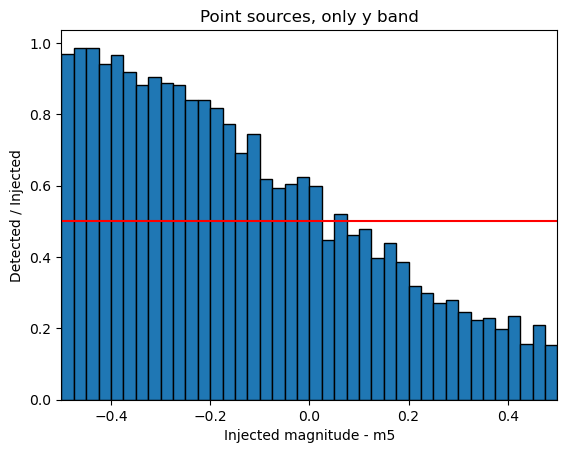

In [36]:
n=41
counts_total, bin_edges = np.histogram (d["mag_delta1"], bins=np.linspace(-0.5, 0.5, n))
counts_detected, bin_edges = np.histogram (d["mag_delta1"][d["detected"]], bins=np.linspace(-0.5, 0.5, n))
plt.bar(bin_edges[:-1], counts_detected/counts_total, width=np.diff(bin_edges), align='edge', edgecolor='black')
plt.xlim(-0.5,0.5)
plt.hlines(0.5, xmin=-1, xmax=1, color="red")
plt.xlabel ("Injected magnitude - m5")
plt.ylabel ("Detected / Injected")
plt.title ("Point sources, only y band")

In [34]:
(d["physical_filter"]=="u").sum()

np.int64(0)

In [61]:
d["visit"] = pd.to_numeric(d["visit"], downcast='integer')
_, i = np.unique(d["visit"], return_index=True)
out = d.iloc[i][["visit", "detector"]].to_markdown(index=False, tablefmt='pipe', colalign=['center']*2, floatfmt='')
out = out.split('\n')
out.pop(1)
out = '\n'.join(out)
print(out)


|      visit      |  detector  |
| 2025080900259.0 |    85.0    |
| 2025080900271.0 |   114.0    |
| 2025080900273.0 |    94.0    |
| 2025080900283.0 |   158.0    |
| 2025081000282.0 |    71.0    |
| 2025081000287.0 |    67.0    |
| 2025081000293.0 |    83.0    |
| 2025081000315.0 |    30.0    |
| 2025081000316.0 |   143.0    |
| 2025081000317.0 |   181.0    |
| 2025081000322.0 |   143.0    |
| 2025081000353.0 |    12.0    |
| 2025081000370.0 |   157.0    |
| 2025081000375.0 |    14.0    |
| 2025081000384.0 |    68.0    |
| 2025081000392.0 |    79.0    |
| 2025081000398.0 |    8.0     |
| 2025081000414.0 |   136.0    |
| 2025081000514.0 |   103.0    |
| 2025081000518.0 |   165.0    |
